## Phase 4.41 - 4.42

# Tensorflow, Deep Neural Networks

## Objectives
- Get some <a href='#background'>background</a> in Tensorflow, Keras (and PyTorch).
- Look at <a href='#tensors'>Tensors</a> and how they're used.
- Start working in <a href='#tensorflow'>Tensorflow</a>!
    - <a href='#preprocessing'>Processing Data</a>.
    - Various methods of <a href='#tuning'>building and tuning a Model</a>.

# Tensorflow / Keras
<a id='background'></a>
## Background

- Keras is an API coded in Python.
- There are three systems built on the Keras API: *Tensorflow*, *Theano*, *CNTK*.
    - *Theano has been discontinued. The last release was 2017, but can still be used.*
- Keras development is backed primarily by Google, and the Keras API comes packaged in TensorFlow as tf.keras.
- **We will use TensorFlow**, as it is the most popular. TensorFlow became the most used Keras backend, and eventually integrated Keras into via the tf.keras submodule of TensorFlow.


> *PyTorch is the leading competitor to Tensorflow based on interest and usage.*
>
> *Many higher education institutions are teaching deep learning via PyTorch. Although not at all necessary to know both, I would recommend to keep PyTorch in your mind and perhaps add to your repertoire as a Data Scientist.*

<a id='tensors'></a>
# Tensors
<img src='./images/tensors.png' width=600>

> **Left:** A "Column"
>
> **Middle:** A "DataFrame"
>
> **Right:** A "multi-dimensional DataFrame". *Most commonly images.*

## Tensors as *Images*

- A Black and White image can be represented as a tensor of shape *$\large (m, n)$* where coordinate $\large (m_i, n_i)$ points to a *pixel*.
<img src='./images/bw_pixel.jpeg' width=300>

- A Color image (rgb) can be represented as a tensor of shape *$\large (m, n, 3)$* where a coordinate $\large (m_i, n_i, r)$ would point to a pixel in layer $\large r$ and $\large (m_i, n_i, b)$ would point to a pixel in layer $\large b$.
<img src='./images/rgb_example.png'>

## Tensors as *Game-States*

> - **AlphaZero**, Google's Reinforcement Learning Neural Network was trained to play games (Go, Chess, Shogi, Starcraft II, others). 
> - This is a two-part model:
    1. A Neural Network and 
    2. a Monte Carlo Tree Search algorithm.
    
    
- 3-dimensional tensors are used as an input and output for the neural network.


- Input is a tensor of shape *$\large (N, N, (MT + L))$*.
    - $N x N$ represents the shape of the board.
        - (8, 8) for chess: *[1-8, a-h]*.
    - $T$ represents a *time-step* for the game.
        - The previous 8-game positions are stored and fed as an input.
    - $M$ represents a binary representation of the presence of the player's pieces on the board, one for each piece-type.
        - 6 piece-types for chess: Pawn, Knight, Bishop, Rook, Queen, King
    - $L$ represents a number of constant-vaues input plantes, denoting aspects of the game-state.
        - Player's color, total move count, special rules (castling, repetition count for that specific position, number of moves "without progress").

<img src='./images/alphazero_input.png' width=500>

#### Fun Facts:
> Match Results: Google's Deep Mind project **AlphaZero** vs reigning WCCC Champion **Stockfish**.
>
> | Game | White | Black | Win | Draw | Loss |
> | ---- | ----- | ----- | --- | ---- | ---- |
> | Chess | AlphaZero | Stockfish | 25 | 25 | 0
> | Chess | Stockfish | AlphaZero | 3 | 47 | 0
>
> - *Stockfish "calculates" 60, 000, 000 positions per second. AlphaZero "calculates" 60, 000 positions per second.*
> - *AlphaZero was trained on 9-hours of training ("self-play").*
>
> Additional Resources and Information:
> <a href='https://arxiv.org/abs/1712.01815'>Mastering Chess and Shogi [...]</a>

<a id='tensorflow'></a>
# Working with Tensorflow

**In this example, we want to be using *DataFrame-shaped* Tensors** $(m, n)$.
*In order to do this, we will want **each row to represent an entire image** and each column to represent a pixel.*

*We will talk about CNNs next - where each row is an entire image, but is **not** flattened first.* 
- E.g.: An input could be represented in shape $(1000, 64, 64, 3)$.*
```
DataShape = (
    {number of images = 1000}, 
    {number of rows (pixels) = 64}, 
    {number of columns (pixels) = 64}, 
    {number of planes (rgb) = 3}
)
```

## Loading Data

In [1]:
import keras
import tensorflow as tf
from tensorflow.keras import layers, Sequential

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
X = digits.images
y = digits.target

In [4]:
X.shape

(1797, 8, 8)

In [5]:
y.shape

(1797,)

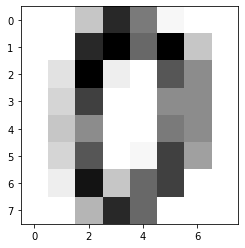

In [6]:
plt.imshow(X[0], cmap='Greys');

In [7]:
# Also, we could access "flat" images directly from this dataset, as seen before.
digits['data'][0].shape

(64,)

In [8]:
digits['data'][0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

<a id='preprocessing'></a>
## Preprocessing
*Not strictly necessary with this toy dataset since the images can be accessed as "flat" already, however we can get a sense of what the preprocessing will be like in Tensorflow.*

- Flatten each image into a row of data.
    - Alternatively, with this example, we could just use `data`.
- Train-test-split into Train, Test, Validation
    - Sizes: (0.7, 0.15, 0.15)
- Scale data to a value [0-1] (pixel intensity)


- One Hot Encode our target.

### Flattening Images

In [9]:
X[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [10]:
# Already a numpy array.
X[0].reshape(-1,)

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [11]:
X_flat = X.reshape(X.shape[0], -1)
X_flat.shape

(1797, 64)

In [12]:
# # Alternate method without using the broadcasting `.reshape`.
# X_flat = np.array([x.reshape(-1,) for x in X])

In [13]:
# Sanity Check
all(digits['data'][0] == X_flat[0])

True

### Target Processing: OneHotEncoder

- Differently from scikit-learn models, Tensorflow multiclass classification models' predictions are an array (a OneHotEncoded version of a multiclass variable).
- Since we are encoding only our target (and we want this representation consistent) we can perform this before the train-test-split.

In [14]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y.reshape(-1, 1))

In [15]:
y_ohe.shape

(1797, 10)

In [16]:
ohe.categories_

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

### Train Test Split
*My go-to train/test/val size is (0.7, 0.15, 0.15), but there is no hard and fast rule on this.*

In [17]:
SEED = 51
TEST_SIZE = int(X_flat.shape[0] * 0.15)

# Number of samples for Test and Val
TEST_SIZE

269

In [18]:
# Split out Test data first.
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_ohe, test_size=TEST_SIZE, random_state=SEED)

# Split Val from training data.
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=SEED)

# Sanity check.
print(f'Train:\n\tX: {X_train.shape}\n\ty: {y_train.shape}')
print(f'Test:\n\tX: {X_test.shape}\n\ty: {y_test.shape}')
print(f'Val:\n\tX: {X_val.shape}\n\ty: {y_val.shape}')

Train:
	X: (1259, 64)
	y: (1259, 10)
Test:
	X: (269, 64)
	y: (269, 10)
Val:
	X: (269, 64)
	y: (269, 10)


### Scaling Data

In [19]:
# Check the max values in each image array.
(max([x for img in X_train for x in img]),
 max([x for img in X_test for x in img]),
 max([x for img in X_val for x in img]))

(16.0, 16.0, 16.0)

*Since pixel data exists with constraints (255 is the maximum value for most images, 16 is the maximum value here), there is no worry of data leakage between data sets.*

In [20]:
# Scaling data.
X_train, X_test, X_val = X_train / 16, X_test / 16, X_val / 16

In [21]:
# Sanity check.
(max([x for img in X_train for x in img]),
 max([x for img in X_test for x in img]),
 max([x for img in X_val for x in img]))

(1.0, 1.0, 1.0)

## Building a Model

- FFNN (Forward-Feed Neural Networks) are named for the way they proceed sequentially through their layers.
- For today, we will only look at this model type.
- In Tensorflow they are part of a class `Sequential`.

In [22]:
# Starting model construction.
model = Sequential()
model

In [23]:
# Adding an input layer.
model.add(
    layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1])
    )

In [24]:
# Adding an output layer.
model.add(
    layers.Dense(units=10, activation='softmax')
    )

- Lastly, we have to define a loss function, a metric, and an optimizer.

- Optimizers are functions which update our weights in smart ways instead of treating all parameters equaly. Adam, a popular optimizer, calculates an individual learning rate for each parameter.

In [25]:
# Compile model with an optimizer, loss function, and preferred metrics.
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

In [26]:
# Show model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 260       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50        
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


## Fitting / Predicting

In [27]:
# Fit
model.fit(X_train, y_train)

40/40 [==============================] - 0s 616us/step - loss: 2.3123 - accuracy: 0.1106


In [28]:
# Predict
model.predict(X_test[[0]])

array([[0.09882435, 0.09911119, 0.10100426, 0.10081807, 0.09951583,
        0.10071516, 0.09956588, 0.10230915, 0.09854412, 0.09959203]],
      dtype=float32)

In [29]:
# Predict class
np.argmax(model.predict(X_test[[0]]), axis=-1)

array([7])

In [30]:
predictions_df = pd.DataFrame(
    zip(ohe.categories_[0], model.predict(X_test[[0]])[0]),
    columns=['Target', 'Softmax']
    )
predictions_df

,Target,Softmax
0,0,0.098824
1,1,0.099111
2,2,0.101004
3,3,0.100818
4,4,0.099516
5,5,0.100715
6,6,0.099566
7,7,0.102309
8,8,0.098544
9,9,0.099592


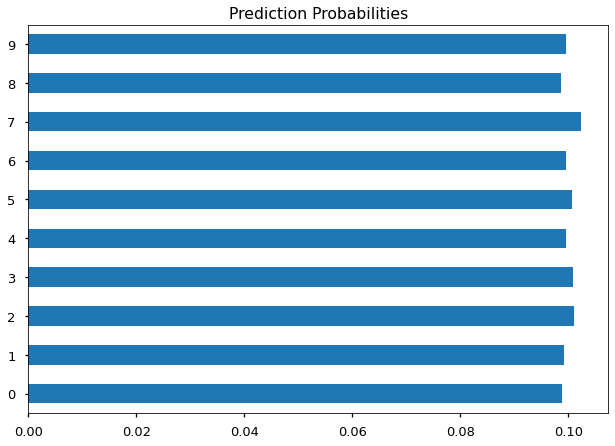

In [31]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots()
    predictions_df['Softmax'].plot(kind='barh')
    ax.set(title='Prediction Probabilities')

In [32]:
# Functionalizing the above.
def plot_prediction_probabilities(trained_model, encoder, entry):
    """
    Show a bar chart representing prediction probabilities.
    """
    
    predictions_df = pd.DataFrame(
        zip(encoder.categories_[0], trained_model.predict(entry)[0]),
        columns=['Target', 'Softmax']
        )
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots()
        predictions_df['Softmax'].plot(kind='barh')
        ax.set(title='Prediction Probabilities')
        plt.show()

## Incorporating Validation Data

In [33]:
# Add validation data.
model.fit(X_train, y_train, validation_data=(X_val, y_val))

40/40 [==============================] - 1s 15ms/step - loss: 2.2515 - accuracy: 0.1565 - val_loss: 2.2056 - val_accuracy: 0.1933


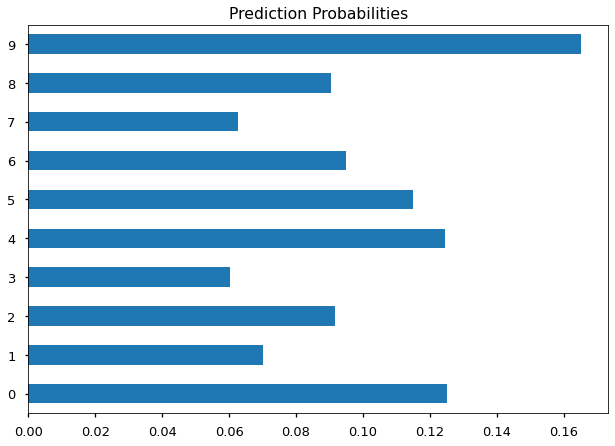

In [34]:
plot_prediction_probabilities(model, ohe, X_train[[0]])

## Add Epochs

In [35]:
# Save the model fit to a variable. Training info is stored here.
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
40/40 [==============================] - 0s 2ms/step - loss: 2.2003 - accuracy: 0.1986 - val_loss: 2.1395 - val_accuracy: 0.2342
Epoch 2/5
40/40 [==============================] - 0s 1ms/step - loss: 2.1422 - accuracy: 0.2168 - val_loss: 2.0734 - val_accuracy: 0.2565
Epoch 3/5
40/40 [==============================] - 0s 3ms/step - loss: 2.0847 - accuracy: 0.2415 - val_loss: 2.0101 - val_accuracy: 0.3197
Epoch 4/5
40/40 [==============================] - 0s 1ms/step - loss: 2.0302 - accuracy: 0.2979 - val_loss: 1.9526 - val_accuracy: 0.3866
Epoch 5/5
40/40 [==============================] - 0s 1ms/step - loss: 1.9769 - accuracy: 0.3384 - val_loss: 1.8963 - val_accuracy: 0.4052


In [36]:
history

In [37]:
history.history

{'loss': [2.200300455093384,
  2.14223051071167,
  2.0847220420837402,
  2.0301740169525146,
  1.976914644241333],
 'accuracy': [0.19857029616832733,
  0.2168387621641159,
  0.24146147072315216,
  0.2978554368019104,
  0.33836376667022705],
 'val_loss': [2.1395390033721924,
  2.0734362602233887,
  2.010064125061035,
  1.9526176452636719,
  1.8962947130203247],
 'val_accuracy': [0.23420074582099915,
  0.2565055787563324,
  0.3197025954723358,
  0.38661709427833557,
  0.4052044749259949]}

In [38]:
def plot_history(history, style=['ggplot', 'seaborn-talk']):
    """
    Plot history from History object (or history dict) 
    once Tensorflow model is trained.
    
    Parameters:
    -----------
    history:
        History object returned from a model.fit()
    style: string or list of strings (default: ['ggplot', 'seaborn-talk'])
        Style from matplotlib.
    """
    
    # We can pass in a model history object or a dictionary.
    if not isinstance(history, dict): # We prefer this type of check over `if type() == ...`
        history = history.history

    metrics_lst = [m for m in history.keys() if not m.startswith('val')]
    N = len(metrics_lst)
    with plt.style.context(style):
        fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 4*(N)))
        ax_lst = [ax_lst] if N == 1 else ax_lst.flatten() # Flatten ax_lst.
        for metric, ax in zip(metrics_lst, ax_lst):
            val_m = f'val_{metric}'
            ax.plot(history[metric], label=metric)
            ax.plot(history[val_m], label=val_m)
            ax.set(title=metric.title(), xlabel='Epoch', ylabel=metric.title())
            ax.legend()
        fig.tight_layout()
        plt.show()

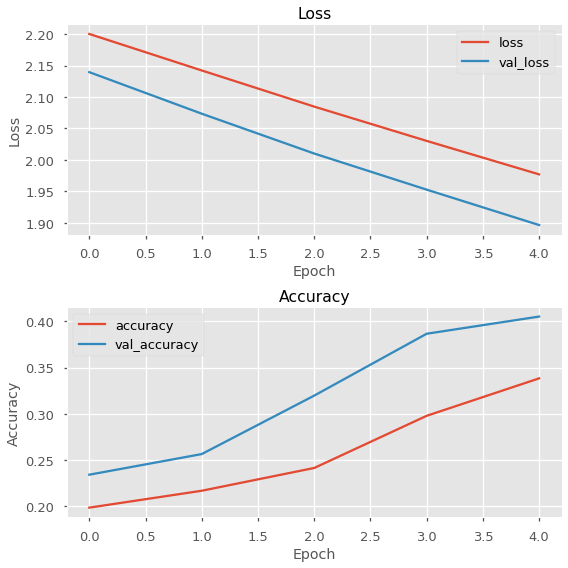

In [39]:
plot_history(history)

In [40]:
# Adding more epochs!
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
40/40 [==============================] - 0s 2ms/step - loss: 1.9238 - accuracy: 0.3558 - val_loss: 1.8395 - val_accuracy: 0.4275
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 1.8721 - accuracy: 0.3844 - val_loss: 1.7847 - val_accuracy: 0.4461
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 1.8216 - accuracy: 0.3940 - val_loss: 1.7309 - val_accuracy: 0.4498
Epoch 4/10
40/40 [==============================] - 0s 1ms/step - loss: 1.7719 - accuracy: 0.4003 - val_loss: 1.6784 - val_accuracy: 0.4647
Epoch 5/10
40/40 [==============================] - 0s 1ms/step - loss: 1.7226 - accuracy: 0.4321 - val_loss: 1.6271 - val_accuracy: 0.4870
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 1.6759 - accuracy: 0.4337 - val_loss: 1.5806 - val_accuracy: 0.5019
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 1.6315 - accuracy: 0.4559 - val_loss: 1.5349 - val_accuracy: 0.5279
Epoch 8/10
40/40 [==

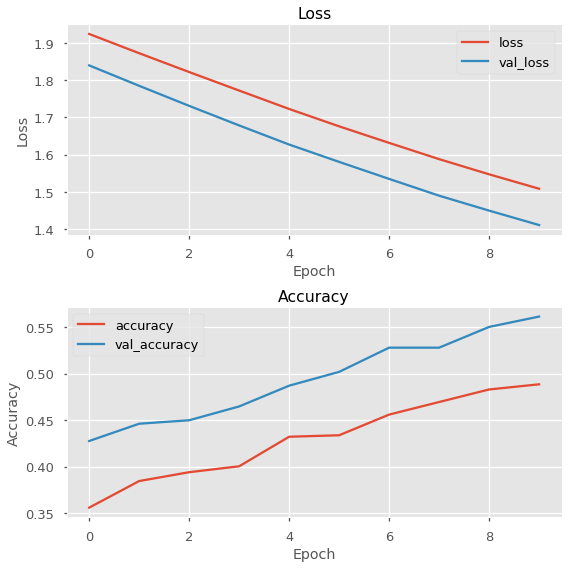

In [41]:
plot_history(history)

## Add Layers
There are no hard set rules for building neural networks. It is an empirical process, where one tries different architectures and see what works. However, it is a good idea to try out deep networks, since we know that successive layers find increasingly complex patterns.

In [42]:
# Building a new model with a hidden layer.
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                70        
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
40/40 [==============================] - 0s 4ms/step - loss: 2.3033 - accuracy: 0.0976 - val_loss: 2.2970 - val_accuracy: 0.1413
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 2.2853 - accuracy: 0.1597 - val_loss: 2.2326 - val_accuracy: 0.1078
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 2.2238 - accuracy: 0.1688 - val_loss: 2.1388 - val_accuracy: 0.2007
Epoch 4/10
40/40 [==============================] - 0s 1ms/step - loss: 2.1353 - accuracy: 0.2522 - val_loss: 2.0225 - val_accuracy: 0.3011
Epoch 5/10
40/40 [==============================] - 0s 1ms/step - loss: 2.0121 - accuracy: 0.3114 - val_loss: 1.8912 - val_accuracy: 0.3680
Epoch 6/10
40/40 [==============================] - 0s 1ms/step - loss: 1.9011 - accuracy: 0.3634 - val_loss: 1.7523 - val_accuracy: 0.3792
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 1.7693 - accuracy: 0.3639 - val_loss: 1.6251 - val_accuracy: 0.4089
Epoch 8/10
40/40 [==

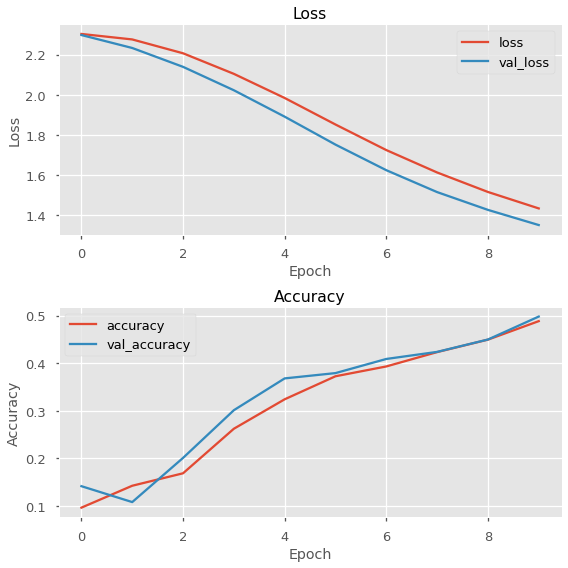

In [44]:
plot_history(history)

In [45]:
# Adding one more layer.
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
Total params: 470
Trainable params: 470
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
40/40 [==============================] - 1s 7ms/step - loss: 2.2522 - accuracy: 0.1264 - val_loss: 2.1849 - val_accuracy: 0.0929
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 2.1454 - accuracy: 0.1175 - val_loss: 2.0796 - val_accuracy: 0.1747
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 2.0256 - accuracy: 0.2129 - val_loss: 1.9659 - val_accuracy: 0.2230
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 1.9150 - accuracy: 0.2510 - val_loss: 1.8359 - val_accuracy: 0.2862
Epoch 5/10
40/40 [==============================] - 0s 1ms/step - loss: 1.7794 - accuracy: 0.3219 - val_loss: 1.7109 - val_accuracy: 0.3420
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 1.6421 - accuracy: 0.3699 - val_loss: 1.5882 - val_accuracy: 0.3866
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 1.5935 - accuracy: 0.3767 - val_loss: 1.4815 - val_accuracy: 0.4387
Epoch 8/10
40/40 [==

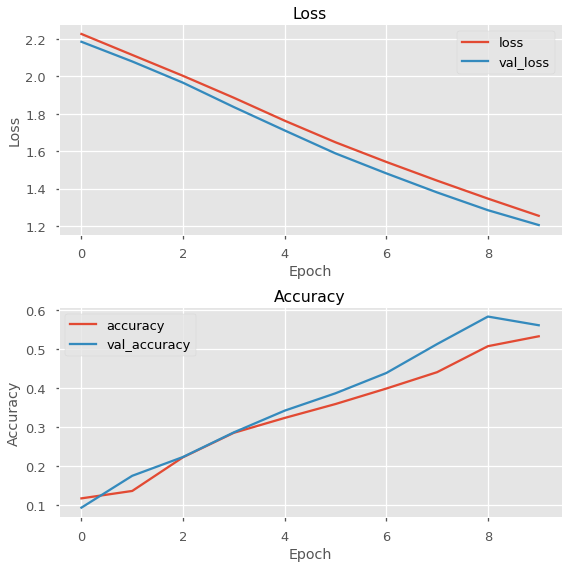

In [47]:
plot_history(history)

## Change Batch Size
By default, we use *mini-batch gradient descent*. We can change this by altering the `batch_size` parameter.

### Mini-Batch

In [48]:
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [49]:
X_train.shape[0]

1259

In [50]:
# Full-batch.
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10,
    batch_size=X_train.shape[0]
    )

Epoch 1/10
1/1 [==============================] - 0s 434ms/step - loss: 2.3161 - accuracy: 0.1390 - val_loss: 2.3433 - val_accuracy: 0.1301
Epoch 2/10
1/1 [==============================] - 0s 30ms/step - loss: 2.3121 - accuracy: 0.1390 - val_loss: 2.3385 - val_accuracy: 0.1301
Epoch 3/10
1/1 [==============================] - 0s 33ms/step - loss: 2.3082 - accuracy: 0.1406 - val_loss: 2.3339 - val_accuracy: 0.1301
Epoch 4/10
1/1 [==============================] - 0s 32ms/step - loss: 2.3044 - accuracy: 0.1438 - val_loss: 2.3294 - val_accuracy: 0.1301
Epoch 5/10
1/1 [==============================] - 0s 31ms/step - loss: 2.3008 - accuracy: 0.1438 - val_loss: 2.3250 - val_accuracy: 0.1264
Epoch 6/10
1/1 [==============================] - 0s 32ms/step - loss: 2.2973 - accuracy: 0.1469 - val_loss: 2.3208 - val_accuracy: 0.1338
Epoch 7/10
1/1 [==============================] - 0s 33ms/step - loss: 2.2940 - accuracy: 0.1485 - val_loss: 2.3168 - val_accuracy: 0.1413
Epoch 8/10
1/1 [==========

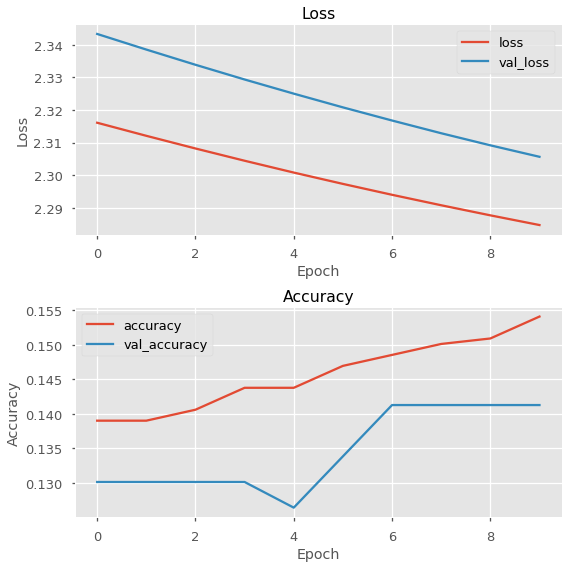

In [51]:
plot_history(history)

### Stochastic Gradient Descent

In [52]:
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="RMSProp", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [53]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10,
    batch_size=1
    )

Epoch 1/10
1259/1259 [==============================] - 1s 813us/step - loss: 2.2446 - accuracy: 0.1438 - val_loss: 1.9995 - val_accuracy: 0.2119
Epoch 2/10
1259/1259 [==============================] - 1s 773us/step - loss: 1.8898 - accuracy: 0.2702 - val_loss: 1.6913 - val_accuracy: 0.3829
Epoch 3/10
1259/1259 [==============================] - 1s 710us/step - loss: 1.6268 - accuracy: 0.4364 - val_loss: 1.4682 - val_accuracy: 0.5093
Epoch 4/10
1259/1259 [==============================] - 1s 802us/step - loss: 1.4269 - accuracy: 0.5206 - val_loss: 1.3383 - val_accuracy: 0.5390
Epoch 5/10
1259/1259 [==============================] - 1s 727us/step - loss: 1.2817 - accuracy: 0.5633 - val_loss: 1.2360 - val_accuracy: 0.5651
Epoch 6/10
1259/1259 [==============================] - 1s 721us/step - loss: 1.2126 - accuracy: 0.5641 - val_loss: 1.1908 - val_accuracy: 0.5948
Epoch 7/10
1259/1259 [==============================] - 1s 708us/step - loss: 1.1930 - accuracy: 0.5690 - val_loss: 1.1838 -

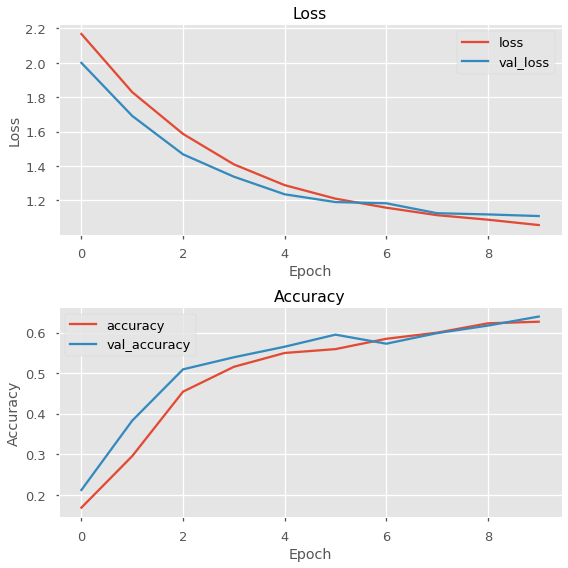

In [54]:
plot_history(history)

<a id='tuning'></a>
# Baseline Model - Before Tuning

In [55]:
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))

model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

model.add(layers.Dense(units=10, activation='softmax'))

model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                90        
Total params: 6,994
Trainable params: 6,994
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 2.2142 - accuracy: 0.1905 - val_loss: 1.8813 - val_accuracy: 0.3792
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 1.8017 - accuracy: 0.3670 - val_loss: 1.4265 - val_accuracy: 0.4981
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 1.3587 - accuracy: 0.5432 - val_loss: 1.0710 - val_accuracy: 0.6617
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.9940 - accuracy: 0.6800 - val_loss: 0.8102 - val_accuracy: 0.6952
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.7560 - accuracy: 0.7544 - val_loss: 0.6008 - val_accuracy: 0.7993
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.5587 - accuracy: 0.8392 - val_loss: 0.4780 - val_accuracy: 0.8587
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.4260 - accuracy: 0.8880 - val_loss: 0.3787 - val_accuracy: 0.8848
Epoch 8/50
40/40 [==

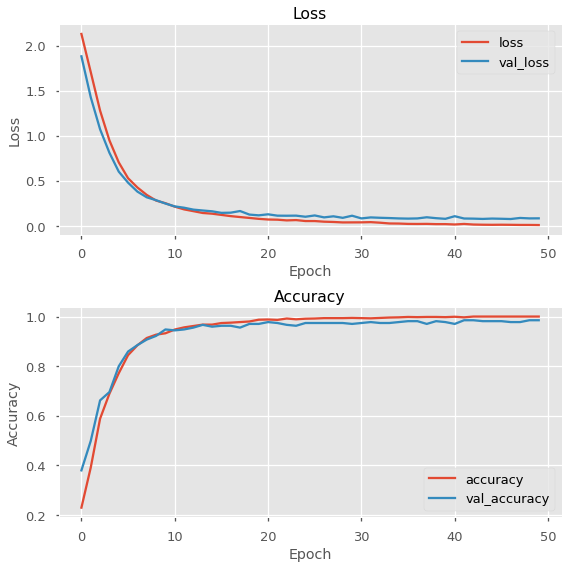

In [57]:
plot_history(history)

# Regularization

In [58]:
from tensorflow.keras import regularizers

In [59]:
# Adding a regularizer to the first hidden layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))

model.add(layers.Dense(units=32, activation='relu', 
                       kernel_regularizer=regularizers.l2())) # L2 Regularizer
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                90        
Total params: 6,994
Trainable params: 6,994
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.6421 - accuracy: 0.1005 - val_loss: 2.3808 - val_accuracy: 0.1710
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.2923 - accuracy: 0.1974 - val_loss: 2.0319 - val_accuracy: 0.2268
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 1.9313 - accuracy: 0.3245 - val_loss: 1.6781 - val_accuracy: 0.4052
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.5533 - accuracy: 0.4584 - val_loss: 1.3164 - val_accuracy: 0.5613
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.2068 - accuracy: 0.6625 - val_loss: 1.0376 - val_accuracy: 0.7138
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.9635 - accuracy: 0.7504 - val_loss: 0.8445 - val_accuracy: 0.7881
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.8164 - accuracy: 0.7995 - val_loss: 0.7333 - val_accuracy: 0.7844
Epoch 8/50
40/40 [==

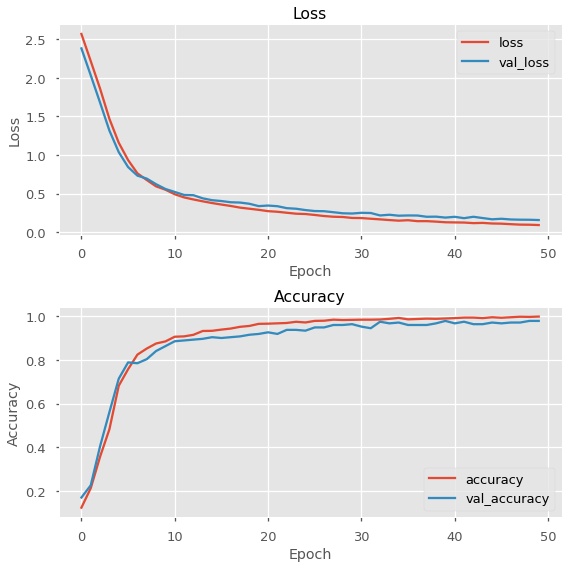

In [61]:
plot_history(history)

In [62]:
# Adding a regularizer to the each layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))
model.add(layers.Dense(units=32, activation='relu', 
                       kernel_regularizer=regularizers.l2()))
model.add(layers.Dense(units=16, activation='relu',
                       kernel_regularizer=regularizers.l2()))
model.add(layers.Dense(units=8, activation='relu',
                       kernel_regularizer=regularizers.l2()))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.9731 - accuracy: 0.1163 - val_loss: 2.7580 - val_accuracy: 0.1524
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.6921 - accuracy: 0.1913 - val_loss: 2.4318 - val_accuracy: 0.2602
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 2.3621 - accuracy: 0.3124 - val_loss: 2.0678 - val_accuracy: 0.3792
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.9831 - accuracy: 0.4139 - val_loss: 1.7516 - val_accuracy: 0.4796
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.7249 - accuracy: 0.4827 - val_loss: 1.5071 - val_accuracy: 0.5688
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 1.4578 - accuracy: 0.5902 - val_loss: 1.2922 - val_accuracy: 0.6803
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 1.2386 - accuracy: 0.6971 - val_loss: 1.1202 - val_accuracy: 0.7435
Epoch 8/50
40/40 [==

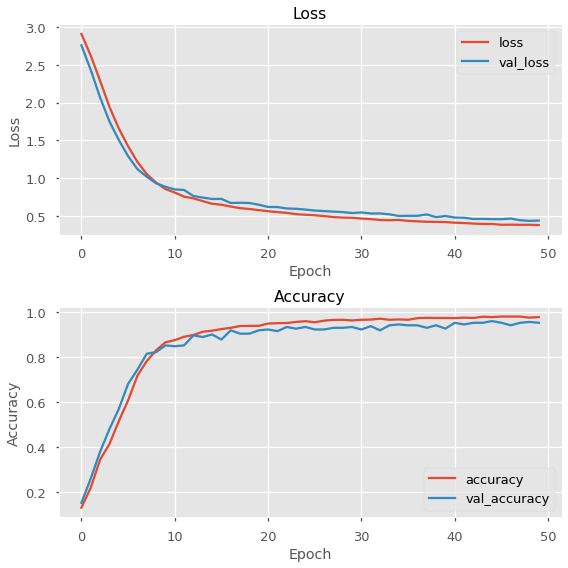

In [63]:
plot_history(history)

# Dropout
<img src='./images/drop_out.png'>

- *Adding dropout will randomly deactivate nodes during training in an attempt to strengthen and clarify the remaining active nodes.*

In [64]:
# Adding dropouts to each layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.3069 - accuracy: 0.1317 - val_loss: 2.2823 - val_accuracy: 0.1710
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 2.2737 - accuracy: 0.1342 - val_loss: 2.2526 - val_accuracy: 0.1450
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 2.2396 - accuracy: 0.1365 - val_loss: 2.1807 - val_accuracy: 0.2082
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 2.1823 - accuracy: 0.1703 - val_loss: 2.0788 - val_accuracy: 0.3717
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 2.1332 - accuracy: 0.1982 - val_loss: 1.9406 - val_accuracy: 0.4387
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 2.0158 - accuracy: 0.2554 - val_loss: 1.8004 - val_accuracy: 0.4572
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 1.9204 - accuracy: 0.3187 - val_loss: 1.6550 - val_accuracy: 0.4833
Epoch 8/50
40/40 [==

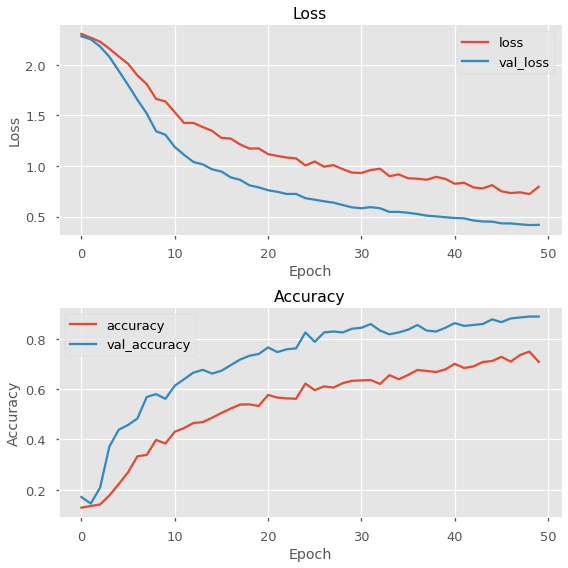

In [65]:
plot_history(history)

In [66]:
# Adding fewer dropouts to each layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 2.2874 - accuracy: 0.1338 - val_loss: 2.1180 - val_accuracy: 0.2974
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.0909 - accuracy: 0.2279 - val_loss: 1.8557 - val_accuracy: 0.3941
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 1.8702 - accuracy: 0.3319 - val_loss: 1.5813 - val_accuracy: 0.5019
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.6706 - accuracy: 0.4134 - val_loss: 1.3486 - val_accuracy: 0.5985
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.3653 - accuracy: 0.5332 - val_loss: 1.1457 - val_accuracy: 0.6320
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 1.2917 - accuracy: 0.5334 - val_loss: 0.9880 - val_accuracy: 0.6877
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1529 - accuracy: 0.5734 - val_loss: 0.8654 - val_accuracy: 0.7323
Epoch 8/50
40/40 [==

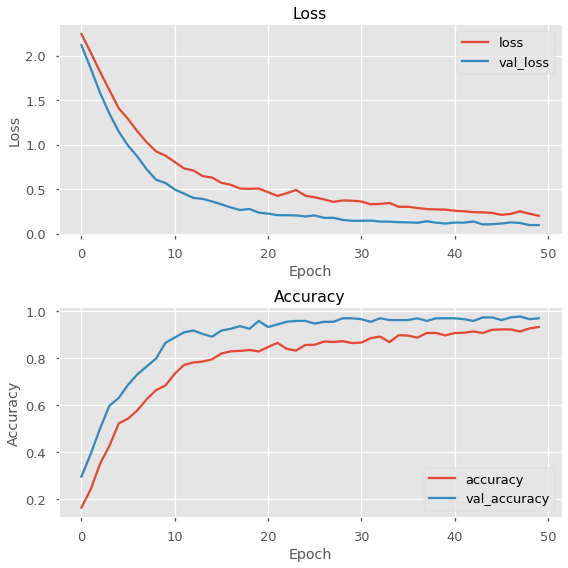

In [67]:
plot_history(history)

# Early Stopping
- *We can have the model stop training before the given number of epochs if it stops improving.*

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
# Adding EarlyStopping.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))

model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=200,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True, verbose=1)]
    )

Epoch 1/200
40/40 [==============================] - 1s 5ms/step - loss: 2.2298 - accuracy: 0.1911 - val_loss: 2.0212 - val_accuracy: 0.3457
Epoch 2/200
40/40 [==============================] - 0s 2ms/step - loss: 1.9415 - accuracy: 0.3785 - val_loss: 1.5716 - val_accuracy: 0.5204
Epoch 3/200
40/40 [==============================] - 0s 2ms/step - loss: 1.4837 - accuracy: 0.5429 - val_loss: 1.1297 - val_accuracy: 0.6617
Epoch 4/200
40/40 [==============================] - 0s 2ms/step - loss: 1.0361 - accuracy: 0.6889 - val_loss: 0.7786 - val_accuracy: 0.7844
Epoch 5/200
40/40 [==============================] - 0s 2ms/step - loss: 0.7326 - accuracy: 0.8370 - val_loss: 0.5637 - val_accuracy: 0.8773
Epoch 6/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5502 - accuracy: 0.8673 - val_loss: 0.4477 - val_accuracy: 0.8662
Epoch 7/200
40/40 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.8863 - val_loss: 0.3453 - val_accuracy: 0.9257
Epoch 8/200
4

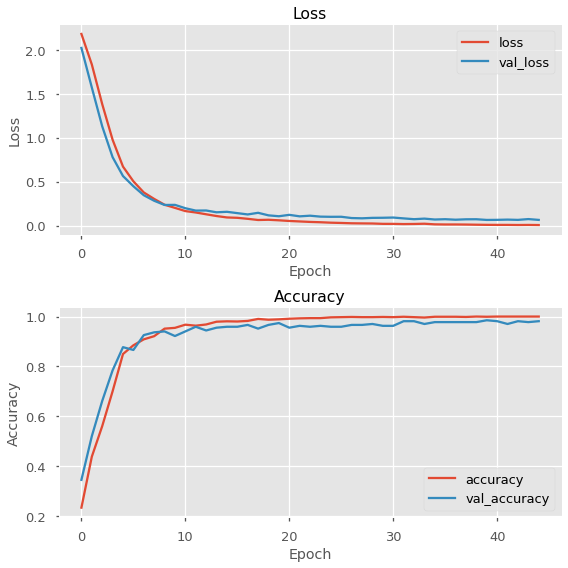

In [70]:
plot_history(history)